In [1]:
import numpy as np
import matplotlib as mpl
mpl.use('pgf')

def textwidth_to_inch(scale):
    fig_width_pt = 427.3153                         # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    return fig_width_pt*inches_per_pt*scale         # width in inches

def figsize(scale):
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = textwidth_to_inch(scale)
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    'axes.titlesize': 10,
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    'lines.linewidth': 1.3, 
    "figure.figsize": figsize(0.9),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

import matplotlib.pyplot as plt

# I make my own newfig and savefig functions
def newfig(width):
    plt.clf()
    fig = plt.figure(figsize=figsize(width))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename):
    plt.savefig('../../text/figures/plots/{}.pgf'.format(filename), bbox_inches='tight')
    plt.savefig('../../text/figures/plots/{}.pdf'.format(filename), bbox_inches='tight')

%matplotlib inline

import pandas as pd

import json
import os
import glob

from math import log
from subprocess import call
from networkit import *

import seaborn as sns
sns.set_style("whitegrid")
mpl.rcParams.update(pgf_with_latex)

In [2]:
data = {}
path = glob.glob(os.path.expanduser("~/dev/ma/data/results/res_plots/dlm-log-*-host-0.json"))[0]

with open(path) as f:
    for line in f.readlines():
        try:
            event = json.loads(line)
            if event['class'] in data:
                data[event['class']].append(event)
            else:
                data[event['class']] = [event]
        except json.JSONDecodeError:
            print('invalid json')
            print(line)

frames = { typename: pd.DataFrame(items) for typename, items in data.items() }

In [3]:
t_zero = min([events['ts'].min() for event_type, events in frames.items()])
for event_type, events in frames.items():
    events['ts'] = (events['ts'] - t_zero) / 1000000 # s
    
frames['MemProfile']['total'] = frames['MemProfile']['total'] / 1000000000 # GB
frames['LinuxProcStats']['pr_rss'] = frames['LinuxProcStats']['pr_rss'] / 1000000000 # GB
frames['NetManager']['total_speed'] = (frames['NetManager']['tx_speed'] + frames['NetManager']['rx_speed']) / 1000000000 # GB/s
frames['NetManager']['rx'] = frames['NetManager']['rx_speed'] / 1000000000 # GB/s
frames['NetManager']['tx'] = frames['NetManager']['tx_speed'] / 1000000000 # GB/s
frames['LinuxProcStats']['total_cpu'] = (frames['LinuxProcStats']['cpu_user'] + frames['LinuxProcStats']['cpu_sys']) * 48 / 17 # %

In [4]:
start = frames['StageBuilder'] \
    .loc[lambda x: x['worker_rank'] == 0] \
    .loc[lambda x: x['id'] == 9] \
    .loc[lambda x: x['event'] == 'execute-done']['ts'].max()
    
contractions = frames['StageBuilder'] \
    .loc[lambda x: x['worker_rank'] == 0] \
    .loc[lambda x: x['label'] == 'GroupByKey'] \
    .loc[lambda x: x['event'] == 'execute-start']
    
first_contraction_id = contractions['id'].min()
iterations = frames['StageBuilder'] \
    .loc[lambda x: x['worker_rank'] == 0] \
    .loc[lambda x: x['label'] == 'FoldByKey'] \
    .loc[lambda x: x['event'] == 'execute-start'] \
    .loc[lambda x: x['id'] < first_contraction_id]

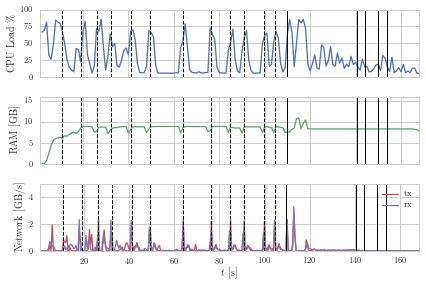

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(textwidth_to_inch(1.15), textwidth_to_inch(0.75)));
plt.subplots_adjust(hspace=0.3);

frames['LinuxProcStats'].plot(x='ts', y='total_cpu', ax=axes[0], sharex=True, legend=False, ylim=(0,100))
axes[0].set_ylabel('CPU Load \%')
frames['LinuxProcStats'].plot(x='ts', y='pr_rss', ax=axes[1], sharex=True, legend=False, color='C1', ylim=(0,16))
axes[1].set_ylabel('RAM [GB]')
frames['NetManager'].plot(x='ts', y=['tx', 'rx'], ax=axes[2], sharex=True, color=['C2', 'C3'], ylim=(0,5))
axes[2].set_ylabel('Network [GB/s]')
axes[2].set_xlabel('$t$ [s]')

for i in [0,1,2]:
    axes[i].axvline(start, color='k', linestyle='dashed', linewidth=1)
    
    for it in iterations['ts']:
        axes[i].axvline(it, color='k', linestyle='dashed', linewidth=1)
        
    for c in contractions['ts']:
        axes[i].axvline(c, color='k', linewidth=1)
        
savefig('dlm_res_plot')

In [6]:
data = {}
path = glob.glob(os.path.expanduser("~/dev/ma/data/results/res_plots/plm-log-*-host-0.json"))[0]

with open(path) as f:
    for line in f.readlines():
        try:
            event = json.loads(line)
            if event['class'] in data:
                data[event['class']].append(event)
            else:
                data[event['class']] = [event]
        except json.JSONDecodeError:
            print('invalid json')
            print(line)

frames = { typename: pd.DataFrame(items) for typename, items in data.items() }

In [7]:
t_zero = min([events['ts'].min() for event_type, events in frames.items()])
for event_type, events in frames.items():
    events['ts'] = (events['ts'] - t_zero) / 1000000 # s
    
frames['MemProfile']['total'] = frames['MemProfile']['total'] / 1000000000 # GB
frames['LinuxProcStats']['pr_rss'] = frames['LinuxProcStats']['pr_rss'] / 1000000000 # GB
frames['NetManager']['total_speed'] = (frames['NetManager']['tx_speed'] + frames['NetManager']['rx_speed']) / 1000000000 # GB/s
frames['NetManager']['rx'] = frames['NetManager']['rx_speed'] / 1000000000 # GB/s
frames['NetManager']['tx'] = frames['NetManager']['tx_speed'] / 1000000000 # GB/s
frames['LinuxProcStats']['total_cpu'] = (frames['LinuxProcStats']['cpu_user'] + frames['LinuxProcStats']['cpu_sys']) * 48 / 17 # %

In [8]:
start = frames['StageBuilder'] \
    .loc[lambda x: x['worker_rank'] == 0] \
    .loc[lambda x: x['id'] == 7] \
    .loc[lambda x: x['event'] == 'pushdata-done']['ts'].min()
    
group_by_keys = frames['StageBuilder'] \
    .loc[lambda x: x['worker_rank'] == 0] \
    .loc[lambda x: x['label'] == 'GroupByKey'] \
    .loc[lambda x: x['event'] == 'execute-start']
contractions = pd.concat([group_by_keys.iloc[1::2, :], group_by_keys.iloc[-1::, :]])

group_to_indexes = frames['StageBuilder'] \
    .loc[lambda x: x['worker_rank'] == 0] \
    .loc[lambda x: x['label'] == 'GroupToIndex'] \
    .loc[lambda x: x['event'] == 'execute-start']

lms = pd.concat([group_to_indexes.loc[lambda x: x['id'] < c_id].iloc[-1::] for c_id in contractions['id']])

group_to_indexes_done = frames['StageBuilder'] \
    .loc[lambda x: x['worker_rank'] == 0] \
    .loc[lambda x: x['label'] == 'GroupToIndex'] \
    .loc[lambda x: x['event'] == 'pushdata-done']

lms_done = pd.concat([group_to_indexes_done.loc[lambda x: x['id'] < c_id].iloc[-1::] for c_id in contractions['id']])

first_lp_iteration_gather_id = frames['StageBuilder'] \
    .loc[lambda x: x['worker_rank'] == 0] \
    .loc[lambda x: x['label'] == 'Gather'] \
    .loc[lambda x: x['event'] == 'execute-start']['id'].min()

iterations = group_to_indexes.loc[lambda x: x['id'] < first_lp_iteration_gather_id].loc[lambda x: x['id'] > 7]

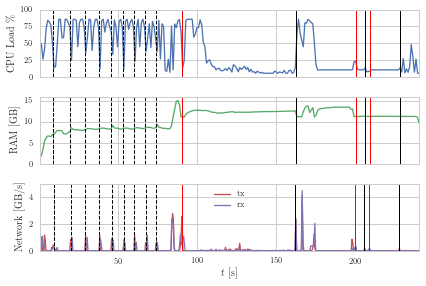

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(textwidth_to_inch(1.15), textwidth_to_inch(0.75)));
plt.subplots_adjust(hspace=0.3);

frames['LinuxProcStats'].plot(x='ts', y='total_cpu', ax=axes[0], sharex=True, legend=False, ylim=(0,100))
axes[0].set_ylabel('CPU Load \%')
frames['LinuxProcStats'].plot(x='ts', y='pr_rss', ax=axes[1], sharex=True, legend=False, color='C1', ylim=(0,16))
axes[1].set_ylabel('RAM [GB]')
frames['NetManager'].plot(x='ts', y=['tx', 'rx'], ax=axes[2], sharex=True, color=['C2', 'C3'], ylim=(0,5))
axes[2].set_ylabel('Network [GB/s]')
axes[2].set_xlabel('$t$ [s]')

for i in [0,1,2]:
    axes[i].axvline(start, color='k', linestyle='dashed', linewidth=1)
    
    for it in iterations['ts']:
        axes[i].axvline(it, color='k', linestyle='dashed', linewidth=1)
        
    for c in contractions['ts']:
        axes[i].axvline(c, color='k', linewidth=1)
        
    for lm in lms['ts']:
        axes[i].axvline(lm, color='r', linewidth=1)
        
savefig('plm_res_plot')